# Setup môi trường

In [1]:
import os
print(os.getcwd())
os.chdir("../../..")
print(os.getcwd())

/home/haipn/Clone/Research_ThyroidFNA_ClassAI/phase3_120924/notebooks/train_module2/with_aug_data_variance0_5
/home/haipn/Clone/Research_ThyroidFNA_ClassAI/phase3_120924


In [2]:
import torch
from src.models.module2.ann import ANN

model = ANN(input_dim=39, output_dim=3, num_hidden=9, num_layers=3, dropout=0.5)
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

570


# Setup data

In [3]:
import pandas as pd

# Đọc dữ liệu từ CSV
data_dir = './data/processed/'
# train_df = pd.read_csv(data_dir + 'train_features.csv').drop(columns=['image_path'])
valid_df = pd.read_csv(data_dir + 'valid_features.csv').drop(columns=['image_path'])
test_df = pd.read_csv(data_dir + 'test_features.csv').drop(columns=['image_path'])

data_dir = './data/augmented/'
train_df_aug = pd.read_csv(data_dir + 'train_augmented_features_variance_0_5.csv')

# Xem cấu trúc của DataFrame
# print('Train DataFrame:')
# print(train_df.head(3))
print('Valid DataFrame:')
print(valid_df.head(3))
print('Test DataFrame:')
print(test_df.head(3))
print('Train Augmented DataFrame:')
print(train_df_aug.head(3))

Valid DataFrame:
   label     dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
0      2 -4.308372 -0.436520  3.545043 -2.595636 -1.076509  3.019734   
1      2 -2.273990 -2.976918  4.630661 -5.481691  1.987185  3.077199   
2      2 -4.070328 -3.232069  6.819434 -3.002290 -1.391492  3.774137   

      dim_6     dim_7     dim_8  ...    dim_29    dim_30    dim_31    dim_32  \
0 -3.748788 -0.974676  4.619431  ...  4.596820 -4.209521 -0.469024  4.025341   
1 -4.994466  1.433963  2.813911  ...  3.553807 -3.890979 -0.693126  4.631985   
2 -2.197132 -2.203136  3.730880  ...  2.323358 -3.455380 -3.436366  6.039357   

     dim_33    dim_34    dim_35    dim_36    dim_37    dim_38  
0 -3.474844 -1.487661  5.017033 -1.916778 -0.383969  2.663312  
1 -2.152809 -0.549343  3.090957 -1.015712 -1.852066  2.541131  
2 -3.923026 -2.357094  5.158929 -4.472951 -3.406128  6.673154  

[3 rows x 40 columns]
Test DataFrame:
   label     dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
0     

In [4]:
import torch
# Tính toán số lượng mẫu của mỗi lớp
class_counts = train_df_aug['label'].value_counts()
total_samples = len(train_df_aug)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

# In ra thông tin trọng số
print("Class Weights (inverse frequency):")
print(class_weights)

# Chuyển đổi trọng số nhãn thành tensor
class_weights_tensor = torch.tensor(sorted(list(class_weights.values()), reverse=True), dtype=torch.float)
print(class_weights_tensor)

Class Weights (inverse frequency):
{2: 0.7698412698412699, 1: 1.1119929453262787, 0: 1.2472799208704253}
tensor([1.2473, 1.1120, 0.7698])


In [5]:
from torch.utils.data import DataLoader, TensorDataset

# Chia dữ liệu thành các tensor
X_train = torch.tensor(train_df_aug.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 39)
y_train = torch.tensor(train_df_aug['label'].values, dtype=torch.long)
X_valid = torch.tensor(valid_df.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 39)
y_valid = torch.tensor(valid_df['label'].values, dtype=torch.long)
X_test = torch.tensor(test_df.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 39)
y_test = torch.tensor(test_df['label'].values, dtype=torch.long)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

# Tạo DataLoader
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=1200, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1200, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1200, shuffle=False)

torch.Size([94575, 39]) torch.Size([94575])
torch.Size([270, 39]) torch.Size([270])
torch.Size([273, 39]) torch.Size([273])


# Huấn luyện mô hình

In [6]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
# set seed
torch.manual_seed(97)

model.to('cuda')
criterion.to('cuda')

num_epochs = 100
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Đánh giá mô hình trên tập validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss:.4f}, Validation Loss: {valid_loss:.4f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_ANN_withAug_var0_5.pth')

Epoch 1/100, Train Loss: 1.1073, Validation Loss: 1.1073
Epoch 2/100, Train Loss: 1.0866, Validation Loss: 1.0866
Epoch 3/100, Train Loss: 1.0471, Validation Loss: 1.0471
Epoch 4/100, Train Loss: 1.0026, Validation Loss: 1.0026
Epoch 5/100, Train Loss: 0.9599, Validation Loss: 0.9599
Epoch 6/100, Train Loss: 0.9111, Validation Loss: 0.9111
Epoch 7/100, Train Loss: 0.8587, Validation Loss: 0.8587
Epoch 8/100, Train Loss: 0.8086, Validation Loss: 0.8086
Epoch 9/100, Train Loss: 0.7644, Validation Loss: 0.7644
Epoch 10/100, Train Loss: 0.7231, Validation Loss: 0.7231
Epoch 11/100, Train Loss: 0.6793, Validation Loss: 0.6793
Epoch 12/100, Train Loss: 0.6406, Validation Loss: 0.6406
Epoch 13/100, Train Loss: 0.6062, Validation Loss: 0.6062
Epoch 14/100, Train Loss: 0.5782, Validation Loss: 0.5782
Epoch 15/100, Train Loss: 0.5556, Validation Loss: 0.5556
Epoch 16/100, Train Loss: 0.5365, Validation Loss: 0.5365
Epoch 17/100, Train Loss: 0.5199, Validation Loss: 0.5199
Epoch 18/100, Train Los

# Kiểm thử

## Trên tập valid


AUC Scores for each class:
0.9675997366629175

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.81      0.84      0.82        81
           2       0.88      0.85      0.86       117

    accuracy                           0.88       270
   macro avg       0.88      0.89      0.88       270
weighted avg       0.88      0.88      0.88       270



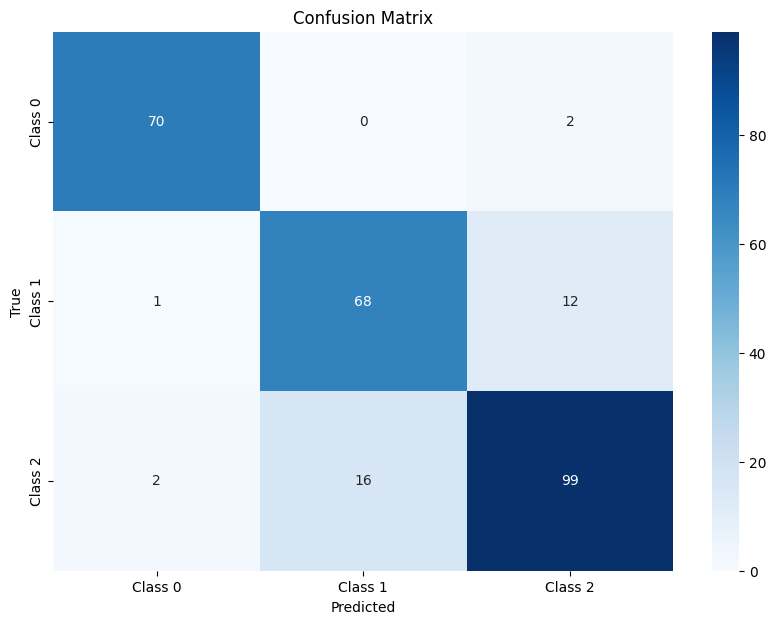

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Load mô hình tốt nhất
model.load_state_dict(torch.load('best_model_ANN_withAug_var0_5.pth', weights_only=True, map_location='cpu'))

# Dự đoán trên tập validation
model.eval()
y_true = []
y_pred = []
y_pred_prob = []  # Lưu xác suất dự đoán cho AUC
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)  # Chuyển đổi đầu ra thành xác suất
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_pred_prob.extend(prob.cpu().numpy())  # Lưu xác suất dự đoán

# Chuyển đổi danh sách thành mảng NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Tính toán confusion matrix và classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Tính toán AUC cho từng lớp
try:
    auc_scores = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    print("\nAUC Scores for each class:")
    print(auc_scores)
except ValueError as e:
    print(f"ValueError: {e}")

print("\nClassification Report:")
print(class_report)

# Vẽ confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Trên tập test


AUC Scores for each class:
0.9576793835537645

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        73
           1       0.74      0.85      0.79        82
           2       0.88      0.83      0.86       118

    accuracy                           0.86       273
   macro avg       0.87      0.87      0.87       273
weighted avg       0.87      0.86      0.86       273



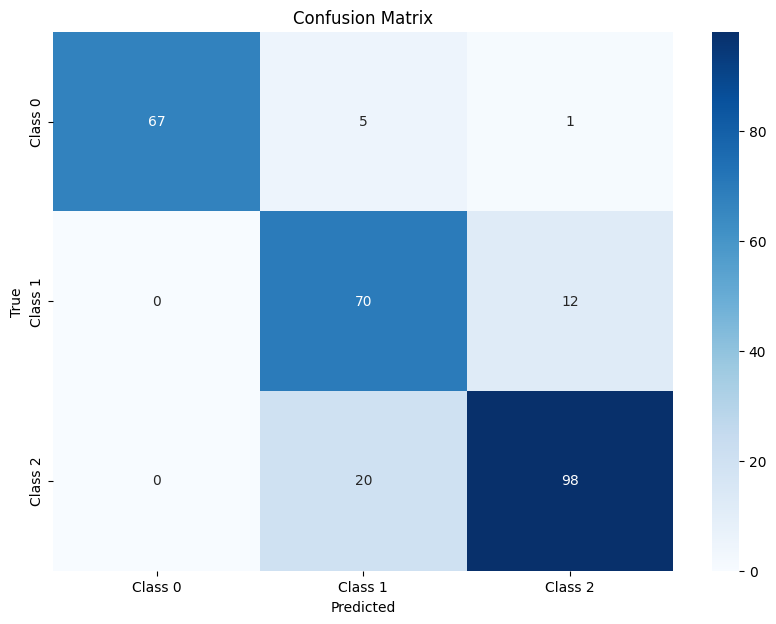

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Load mô hình tốt nhất
model.load_state_dict(torch.load('best_model_ANN_withAug_var0_5.pth', weights_only=True, map_location='cpu'))

# Dự đoán trên tập validation
model.eval()
y_true = []
y_pred = []
y_pred_prob = []  # Lưu xác suất dự đoán cho AUC
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        prob = F.softmax(outputs, dim=1)  # Chuyển đổi đầu ra thành xác suất
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_pred_prob.extend(prob.cpu().numpy())  # Lưu xác suất dự đoán

# Chuyển đổi danh sách thành mảng NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_prob = np.array(y_pred_prob)

# Tính toán confusion matrix và classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Tính toán AUC cho từng lớp
try:
    auc_scores = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    print("\nAUC Scores for each class:")
    print(auc_scores)
except ValueError as e:
    print(f"ValueError: {e}")

print("\nClassification Report:")
print(class_report)

# Vẽ confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()